In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# from lenstools.simulations import Gadget2Snapshot

In [3]:
from other_lib.read_binary_gadget import read_binary_gadget

In [51]:
snapshot_file = "/usr1/student/premv/Documents/snapshot_200.3"

In [52]:
snapshot = read_binary_gadget(snapshot_file)

reading the first block (header) which contains  [256]  bytes
Header block is read and it contains  256 bytes


In [53]:
# dir(snapshot)

In [54]:
snapshot.BoxSize

150.0

In [55]:
snapshot.NumPart_ThisFile[1]

133874731

In [56]:
snapshot.NumFilesPerSnapshot

8

In [57]:
snapshot.HubbleParam

0.7

In [58]:
snapshot.NumPart_Total[1]

1073741824

In [59]:
posd = snapshot.read_posd()

reading the second block (position) which contains  1606496772  bytes
Position block is read and it contains  1606496772 bytes


In [60]:
posd[184393,:]

array([107.985596,  39.60013 ,  27.59664 ], dtype=float32)

In [61]:
# snapshot.g.seek(256+4,0)

In [62]:
# np.fromfile(snapshot.g,dtype = np.int32,count =1)[0]

In [63]:
posd.shape

(133874731, 3)

In [64]:
posd.nbytes/12

133874731.0

In [65]:
np.amax(posd,0)

array([149.99998 ,  74.999985, 112.53748 ], dtype=float32)

In [67]:
np.amin(posd,0)

array([74.99999,  0.     , 18.69375], dtype=float32)

In [19]:
def assign_func_ngp(cell_size):
    return lambda diff : 1 if diff < cell_size/2 else 0

def assign_func_cic(cell_size):
    return lambda diff : 1 - diff/cell_size if diff < cell_size else 0

def assign_func_tsc(cell_size):
    def W(diff):
        if diff < cell_size/2:
            return 3/4 - (diff/cell_size)**2
        elif diff < 3*cell_size/2:
            return 1/2 * (3/2 - diff/cell_size)**2
        else:
            return 0
    return W

Text(0.5, 1.0, 'Density assignment function for cell size of 10')

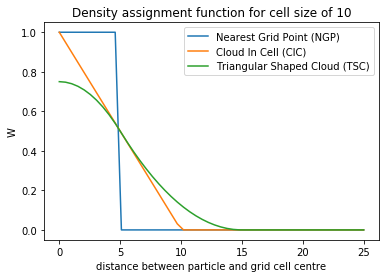

In [20]:
d = np.linspace (0,25)
plt.plot(d,np.vectorize(assign_func_ngp(10))(d),label='Nearest Grid Point (NGP)')
plt.plot(d,np.vectorize(assign_func_cic(10))(d),label='Cloud In Cell (CIC)')
plt.plot(d,np.vectorize(assign_func_tsc(10))(d),label='Triangular Shaped Cloud (TSC)')
plt.legend()
plt.xlabel("distance between particle and grid cell centre")
plt.ylabel("W")
plt.title("Density assignment function for cell size of 10")

In [21]:
shape = (128,)*3
density_grid = np.zeros(shape)

In [22]:
density_grid.shape

(128, 128, 128)

In [23]:
# grid = np.indices(shape)
# grid[:,np.array([1,2])[:,None],[2,5,3],3]

In [24]:
# np.array([1,2])[:,None]

In [25]:
W = np.vectorize(assign_func_cic(1))

In [26]:
# posd = np.array([[4,4,3.6],[4,4,4]])

In [27]:
# from numba import jit

In [47]:
def assign_to_grid(posdi):
    global density_grid
    posgrid = posdi.astype(np.uint16)   # scale position units in terms of grid cell size.
    cell_indices = (np.array([posgrid[j],posgrid[j]+1]) for j in range(3))
    cells = np.meshgrid(*cell_indices)  # Cell index = position of cell centre, so index 7 is cell from 6.5 to 7.5
    density_grid[tuple(cells)] += np.prod(W(np.abs(np.array(cells) - posdi[:,None,None,None])),axis=0) 

In [49]:
# for i in range(posd.shape[0]):
#     assign_to_grid(posd[i])

In [54]:
for i in range(20000):
# for i in range(posd.shape[0]):
    posgrid = posd[i].astype(np.uint16)   # scale position units in terms of grid cell size.
    cell_indices = (np.array([posgrid[j],posgrid[j]+1]) for j in range(3))
    cells = np.meshgrid(*cell_indices)  # Cell index = position of cell centre, so index 7 is cell from 6.5 to 7.5
    density_grid[tuple(cells)] += np.prod(W(np.abs(np.array(cells) - posd[i,:,None,None,None])),axis=0)    

In [55]:
posd.shape[0]/i

6658.330366518326

In [56]:
density_grid.nbytes

16777216

In [57]:
density_grid[4,4,4]

2345.8169721158247

In [92]:
density_grids = []

In [93]:
for i in range(4):
    dens_grid = np.fromfile("density_assign/density_grid.{}".format(i), dtype=np.float32, count=160**3)
    density_grids.append(dens_grid.reshape([160,160,160]))

In [94]:
density_grid = np.array(density_grids).sum(0)
density_grid.shape

(160, 160, 160)

In [95]:
log_density_grid = np.log(density_grid+1e-2)

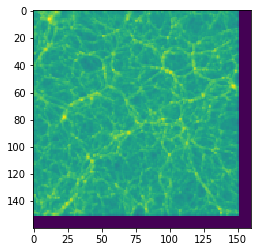

In [96]:
plt.imshow(log_density_grid[:,:,10])

In [107]:
# Jupyter based interaction
from ipywidgets import interact
# fig2, ax2 = plt.subplots(dpi=120)
@interact(third_direction=(0,160))
def show2D(third_direction):
    print("third {}".format(third_direction))
    plt.imshow(log_density_grid[:,:,int(third_direction)])

interactive(children=(IntSlider(value=80, description='third_direction', max=160), Output()), _dom_classes=('w…

In [29]:
posd.shape

(133159949, 3)

In [47]:
posd[i,0]-posgrid[0]

0.26598287

In [48]:
posgrid

array([3, 0, 2], dtype=uint16)

In [49]:
posd[i]

array([3.2659829 , 0.31818238, 2.962007  ], dtype=float32)

In [50]:
np.meshgrid(posgrid,posgrid)[0]

array([[3, 0, 2],
       [3, 0, 2],
       [3, 0, 2]], dtype=uint16)

In [51]:
posgrid = posd[i].astype(np.uint16)
xs = np.array([posgrid[0],posgrid[0]+1])
ys = np.array([posgrid[1],posgrid[1]+1])
zs = np.array([posgrid[2],posgrid[2]+1])
cells = tuple(np.meshgrid(xs,ys,zs))

In [52]:
cells

(array([[[3, 3],
         [4, 4]],
 
        [[3, 3],
         [4, 4]]]), array([[[0, 0],
         [0, 0]],
 
        [[1, 1],
         [1, 1]]]), array([[[2, 3],
         [2, 3]],
 
        [[2, 3],
         [2, 3]]]))

In [53]:
cell_indices = (np.array([posgrid[j],posgrid[j]+1]) for j in range(3))
cells = np.meshgrid(*cell_indices)

In [54]:
cells

[array([[[3, 3],
         [4, 4]],
 
        [[3, 3],
         [4, 4]]]), array([[[0, 0],
         [0, 0]],
 
        [[1, 1],
         [1, 1]]]), array([[[2, 3],
         [2, 3]],
 
        [[2, 3],
         [2, 3]]])]

In [55]:
W(np.abs(np.array(cells) - posd[i,:,None,None,None]))

array([[[[0.73401713, 0.73401713],
         [0.26598287, 0.26598287]],

        [[0.73401713, 0.73401713],
         [0.26598287, 0.26598287]]],


       [[[0.68181762, 0.68181762],
         [0.68181762, 0.68181762]],

        [[0.31818238, 0.31818238],
         [0.31818238, 0.31818238]]],


       [[[0.03799295, 0.96200705],
         [0.03799295, 0.96200705]],

        [[0.03799295, 0.96200705],
         [0.03799295, 0.96200705]]]])